# Data Analysis
Lets start by importing the necessary libraries


In [1]:
# Import necessary libraries
import modin.pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
from rich import print
import json

Now lets make sure that ray or dask is  not running

In [2]:
try:
    import ray
    if ray.is_initialized():
        print("Ray is running. Shutting down the cluster...")
        ray.shutdown()
    else:
        print("Ray is not running.")
except ImportError:
    print("Ray is not installed. Skipping Ray shutdown.")

try:
    from dask.distributed import get_client
    try:
        client = get_client()
        print("Dask client detected. Shutting down the client...")
        client.shutdown()
    except ValueError:
        print("No running Dask client found.")
except ImportError:
    print("Dask is not installed. Skipping Dask shutdown.")


Ray is not running.

No running Dask client found.

now lets init ray as the defulat but lets make it so we can change if we so desire

In [3]:
# Variable to choose computation framework: "ray" or "dask" (default is "ray")
framework_choice: str = "ray"  # change this value to "dask" if desired

if framework_choice.lower() == "ray":
    try:
        import ray
        if not ray.is_initialized():
            ray.init(ignore_reinit_error=True)
            print("Ray has been initialized.")
        else:
            print("Ray is already running.")
    except ImportError:
        print("Ray is not installed. Please install it using: uv pip install ray")
elif framework_choice.lower() == "dask":
    try:
        from dask.distributed import Client
        client = Client()
        print("Dask client has been initialized.")
    except ImportError:
        print("Dask is not installed. Please install it using: uv pip install dask distributed")
else:
    print("Invalid framework choice. Please set framework_choice to either 'ray' or 'dask'.")


2025-02-18 13:50:04,027	INFO worker.py:1841 -- Started a local Ray instance.


Ray has been initialized.

## Style
lets pick a nice color palette


In [5]:
# Set style for better visualizations using a valid matplotlib style name
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")

# Load the data
Ok now to load the data, we need to know the path to the data.

The data i stored in the Data folder at root and has several files.


In [6]:
# Define data paths
DATA_DIR = Path("../Data")
AARSLEV_DIR = DATA_DIR / "aarslev"
KNUDJEPSEN_DIR = DATA_DIR / "knudjepsen"

Lets inspect the data by looking at the first few rows.

In [7]:
import modin.pandas as pd
from IPython.display import display

# Loop over the two defined data directories and display the first few rows of the first CSV file found in each.
for data_dir in [AARSLEV_DIR, KNUDJEPSEN_DIR]:
    csv_files = list(data_dir.glob("*.csv"))
    if csv_files:
        csv_file = csv_files[0]
        try:
            df: pd.DataFrame = pd.read_csv(csv_file)
            print(f"Displaying first few rows of '{csv_file.name}' from directory '{data_dir.name}':")
            display(df.head())
        except Exception as e:
            print(f"Error reading {csv_file}: {e}")
    else:
        print(f"No CSV files found in directory '{data_dir.name}'")


Displaying first few rows of 'data_jan_feb_2014.csv' from directory 'aarslev':

,timestamp;temperature_forecast;sun_radiation_forecast;sun_radiation;temperature
0,1390518000000;-4.250;0.000;0.000;-3.864
1,1390521600000;-4.480;0.000;0.000;-4.010
2,1390525200000;-4.620;0.000;0.000;-4.176
3,1390528800000;-4.720;0.000;0.000;-3.844
4,1390532400000;-4.610;0.000;0.000;-4.059


Displaying first few rows of 'NO3-NO4_belysningsgrp.csv' from directory 'knudjepsen':

,";""målt status"";""målt status"";""målt status"";""målt status"";""målt status"";""målt status"""
0,";""NORRING:BEL.SYSTEM 3 LAMPGRP 1"";""NORRING:BEL..."
1,";"""";"""";"""";"""";"""";"""""
2,07-09-2015 00:00:00;0;0;0;0;0;0
3,07-09-2015 00:05:00;0;0;0;0;0;0
4,07-09-2015 00:10:00;0;0;0;0;0;0


This didnt really look that good lets try to clean it up a little.

In [22]:
# --- Load aarslev forecast data ---
aarslev_file = AARSLEV_DIR / "data_jan_feb_2014.csv"

aarslev_df: pd.DataFrame = pd.read_csv(aarslev_file, sep=";")
print("DataFrame info for aarslev forecast data:")
aarslev_df.info()
display(aarslev_df.head())



# --- Load knudjepsen measured data ---
knudjepsen_file = KNUDJEPSEN_DIR / "NO3-NO4_belysningsgrp.csv"
knudjepsen_df: pd.DataFrame = pd.read_csv(knudjepsen_file, sep=";")
print("DataFrame info for knudjepsen forecast data:")
knudjepsen_df.info()
display(knudjepsen_df.head())


DataFrame info for aarslev forecast data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528 entries, 0 to 527
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   timestamp               528 non-null    int64  
 1   temperature_forecast    528 non-null    float64
 2   sun_radiation_forecast  528 non-null    float64
 3   sun_radiation           528 non-null    float64
 4   temperature             528 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 20.8 KB


,timestamp,temperature_forecast,sun_radiation_forecast,sun_radiation,temperature
0,1390518000000,-4.25,0.0,0.0,-3.864
1,1390521600000,-4.48,0.0,0.0,-4.010
2,1390525200000,-4.62,0.0,0.0,-4.176
3,1390528800000,-4.72,0.0,0.0,-3.844
4,1390532400000,-4.61,0.0,0.0,-4.059


DataFrame info for knudjepsen forecast data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105699 entries, 0 to 105698
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     105697 non-null  object
 1   målt status    102264 non-null  object
 2   målt status.1  102264 non-null  object
 3   målt status.2  102264 non-null  object
 4   målt status.3  102264 non-null  object
 5   målt status.4  102264 non-null  object
 6   målt status.5  102264 non-null  object
dtypes: object(7)
memory usage: 5.6+ MB


,Unnamed: 0,målt status,målt status.1,målt status.2,målt status.3,målt status.4,målt status.5
0,NaN,NORRING:BEL.SYSTEM 3 LAMPGRP 1,NORRING:BEL.SYSTEM 3 LAMPGRP 2,NORRING:BEL.SYSTEM 3 LAMPGRP 3,NORRING:BEL.SYSTEM 3 LAMPGRP 4,NORRING:BEL.SYSTEM 4 LAMPGRP 1,NORRING:BEL.SYSTEM 4 LAMPGRP 2
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,07-09-2015 00:00:00,0,0,0,0,0,0
3,07-09-2015 00:05:00,0,0,0,0,0,0
4,07-09-2015 00:10:00,0,0,0,0,0,0


Lets try to clean and standardize.
first let me fix the time for aarslev

In [23]:
# Convert timestamp to datetime (for aarslev forecast data)
aarslev_df["datetime"] = pd.to_datetime(aarslev_df["timestamp"], unit="ms")
# Inspect the new column and ensure all other columns are as expected
print("Aarslev Forecast Data:")
aarslev_df.info()
display(aarslev_df.head())

Aarslev Forecast Data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528 entries, 0 to 527
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   timestamp               528 non-null    int64         
 1   temperature_forecast    528 non-null    float64       
 2   sun_radiation_forecast  528 non-null    float64       
 3   sun_radiation           528 non-null    float64       
 4   temperature             528 non-null    float64       
 5   datetime                528 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 24.9 KB


,timestamp,temperature_forecast,sun_radiation_forecast,sun_radiation,temperature,datetime
0,1390518000000,-4.25,0.0,0.0,-3.864,2014-01-23 23:00:00
1,1390521600000,-4.48,0.0,0.0,-4.010,2014-01-24 00:00:00
2,1390525200000,-4.62,0.0,0.0,-4.176,2014-01-24 01:00:00
3,1390528800000,-4.72,0.0,0.0,-3.844,2014-01-24 02:00:00
4,1390532400000,-4.61,0.0,0.0,-4.059,2014-01-24 03:00:00


Looks better.

now lets look at knudjensen

In [13]:
# Rename the first column to 'datetime'
if "Unnamed: 0" in knudjepsen_df.columns:
    knudjepsen_df.rename(columns={"Unnamed: 0": "datetime"}, inplace=True)

# Convert the datetime column assuming the format is day-month-year (e.g., "07-09-2015 00:00:00")
knudjepsen_df["datetime"] = pd.to_datetime(knudjepsen_df["datetime"], dayfirst=True, errors="coerce")

# Optionally, drop any unwanted columns (for example, if 'Unnamed: 0' was useful just as an index, you might drop it)
# knudjepsen_df = knudjepsen_df.drop(columns=["Unnamed: 0"])  # Uncomment if needed

print("Knudjepsen Measured Data:")
knudjepsen_df.info()
display(knudjepsen_df.head())

Knudjepsen Measured Data:

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 105699 entries, 0 to 105698
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   datetime       105697 non-null  datetime64[ns]
 1   målt status    102264 non-null  object        
 2   målt status.1  102264 non-null  object        
 3   målt status.2  102264 non-null  object        
 4   målt status.3  102264 non-null  object        
 5   målt status.4  102264 non-null  object        
 6   målt status.5  102264 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 5.6+ MB


,datetime,målt status,målt status.1,målt status.2,målt status.3,målt status.4,målt status.5
0,NaT,NORRING:BEL.SYSTEM 3 LAMPGRP 1,NORRING:BEL.SYSTEM 3 LAMPGRP 2,NORRING:BEL.SYSTEM 3 LAMPGRP 3,NORRING:BEL.SYSTEM 3 LAMPGRP 4,NORRING:BEL.SYSTEM 4 LAMPGRP 1,NORRING:BEL.SYSTEM 4 LAMPGRP 2
1,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-09-07 00:00:00,0,0,0,0,0,0
3,2015-09-07 00:05:00,0,0,0,0,0,0
4,2015-09-07 00:10:00,0,0,0,0,0,0


Ive notised that the first row of knudjepsen is about lamp groups ill try to clean so that this row isnt included but is used as headers

In [15]:
# --- Distinguish Between Different Lamp Groups ---

# Check if the first row contains non-datetime labels (i.e., lamp group names)
if pd.isna(knudjepsen_df.loc[0, "datetime"]):
    # Create a mapping for sensor columns based on the first row
    sensor_mapping = {
        col: knudjepsen_df.loc[0, col]
        for col in knudjepsen_df.columns if col != "datetime"
    }
    # Rename sensor columns using the mapping
    knudjepsen_df = knudjepsen_df.rename(columns=sensor_mapping)
    # Drop the first row since it now served its purpose as a header for lamp groups
    knudjepsen_df = knudjepsen_df.drop(index=0).reset_index(drop=True)

# Parse the datetime column (assuming day-first format, e.g., "07-09-2015 00:00:00")
knudjepsen_df["datetime"] = pd.to_datetime(knudjepsen_df["datetime"], dayfirst=True, errors="coerce")

# Convert all the sensor (lamp group) columns to a numeric type
sensor_cols = [col for col in knudjepsen_df.columns if col != "datetime"]
for col in sensor_cols:
    knudjepsen_df[col] = pd.to_numeric(knudjepsen_df[col], errors="coerce")

print("Cleaned knudjepsen data with lamp groups distinguished:")
knudjepsen_df.info()
display(knudjepsen_df.head())

# --- (Optional) Reshape to Long Format ---
# If you later want to analyze the individual measurements more easily,
# you can melt the dataframe from wide to long format.
knudjepsen_long = knudjepsen_df.melt(
    id_vars="datetime",
    var_name="lamp_group",
    value_name="measurement"
)
print("Long format knudjepsen data:")
display(knudjepsen_long.head())

Cleaned knudjepsen data with lamp groups distinguished:

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 105698 entries, 0 to 105697
Data columns (total 7 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   datetime                        105697 non-null  datetime64[ns]
 1   NORRING:BEL.SYSTEM 3 LAMPGRP 1  102263 non-null  float64       
 2   NORRING:BEL.SYSTEM 3 LAMPGRP 2  102263 non-null  float64       
 3   NORRING:BEL.SYSTEM 3 LAMPGRP 3  102263 non-null  float64       
 4   NORRING:BEL.SYSTEM 3 LAMPGRP 4  102263 non-null  float64       
 5   NORRING:BEL.SYSTEM 4 LAMPGRP 1  102263 non-null  float64       
 6   NORRING:BEL.SYSTEM 4 LAMPGRP 2  102263 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 5.6 MB


,datetime,NORRING:BEL.SYSTEM 3 LAMPGRP 1,NORRING:BEL.SYSTEM 3 LAMPGRP 2,NORRING:BEL.SYSTEM 3 LAMPGRP 3,NORRING:BEL.SYSTEM 3 LAMPGRP 4,NORRING:BEL.SYSTEM 4 LAMPGRP 1,NORRING:BEL.SYSTEM 4 LAMPGRP 2
0,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-09-07 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0
2,2015-09-07 00:05:00,0.0,0.0,0.0,0.0,0.0,0.0
3,2015-09-07 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0
4,2015-09-07 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0


Order of rows could be different from pandas.


Long format knudjepsen data:

,datetime,lamp_group,measurement
0,NaT,NORRING:BEL.SYSTEM 3 LAMPGRP 1,NaN
1,2015-09-07 00:00:00,NORRING:BEL.SYSTEM 3 LAMPGRP 1,0.0
2,2015-09-07 00:05:00,NORRING:BEL.SYSTEM 3 LAMPGRP 1,0.0
3,2015-09-07 00:10:00,NORRING:BEL.SYSTEM 3 LAMPGRP 1,0.0
4,2015-09-07 00:15:00,NORRING:BEL.SYSTEM 3 LAMPGRP 1,0.0


Okay i noticed that there are a lot of 0 measurements, lets see if thre is actual data in the file

In [16]:
# Check summary statistics for one sensor column (e.g., lamp group 1)
print("Summary statistics for NORRING:BEL.SYSTEM 3 LAMPGRP 1:")
display(knudjepsen_df["NORRING:BEL.SYSTEM 3 LAMPGRP 1"].describe())

# You can loop over all sensor columns
sensor_cols = [col for col in knudjepsen_df.columns if col != "datetime"]
for col in sensor_cols:
    print(f"Summary statistics for {col}:")
    display(knudjepsen_df[col].describe())

Summary statistics for NORRING:BEL.SYSTEM 3 LAMPGRP 1:

count    102263.000000
mean          0.142720
std           0.349789
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: NORRING:BEL.SYSTEM 3 LAMPGRP 1, dtype: float64

Summary statistics for NORRING:BEL.SYSTEM 3 LAMPGRP 1:

count    102263.000000
mean          0.142720
std           0.349789
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: NORRING:BEL.SYSTEM 3 LAMPGRP 1, dtype: float64

Summary statistics for NORRING:BEL.SYSTEM 3 LAMPGRP 2:

count    102263.000000
mean          0.142398
std           0.349459
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: NORRING:BEL.SYSTEM 3 LAMPGRP 2, dtype: float64

Summary statistics for NORRING:BEL.SYSTEM 3 LAMPGRP 3:

count    102263.000000
mean          0.142671
std           0.349739
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: NORRING:BEL.SYSTEM 3 LAMPGRP 3, dtype: float64

Summary statistics for NORRING:BEL.SYSTEM 3 LAMPGRP 4:

count    102263.000000
mean          0.142710
std           0.349779
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: NORRING:BEL.SYSTEM 3 LAMPGRP 4, dtype: float64

Summary statistics for NORRING:BEL.SYSTEM 4 LAMPGRP 1:

count    102263.000000
mean          0.202634
std           0.401964
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: NORRING:BEL.SYSTEM 4 LAMPGRP 1, dtype: float64

Summary statistics for NORRING:BEL.SYSTEM 4 LAMPGRP 2:

count    102263.000000
mean          0.202243
std           0.401675
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: NORRING:BEL.SYSTEM 4 LAMPGRP 2, dtype: float64

Lets try and visualise now

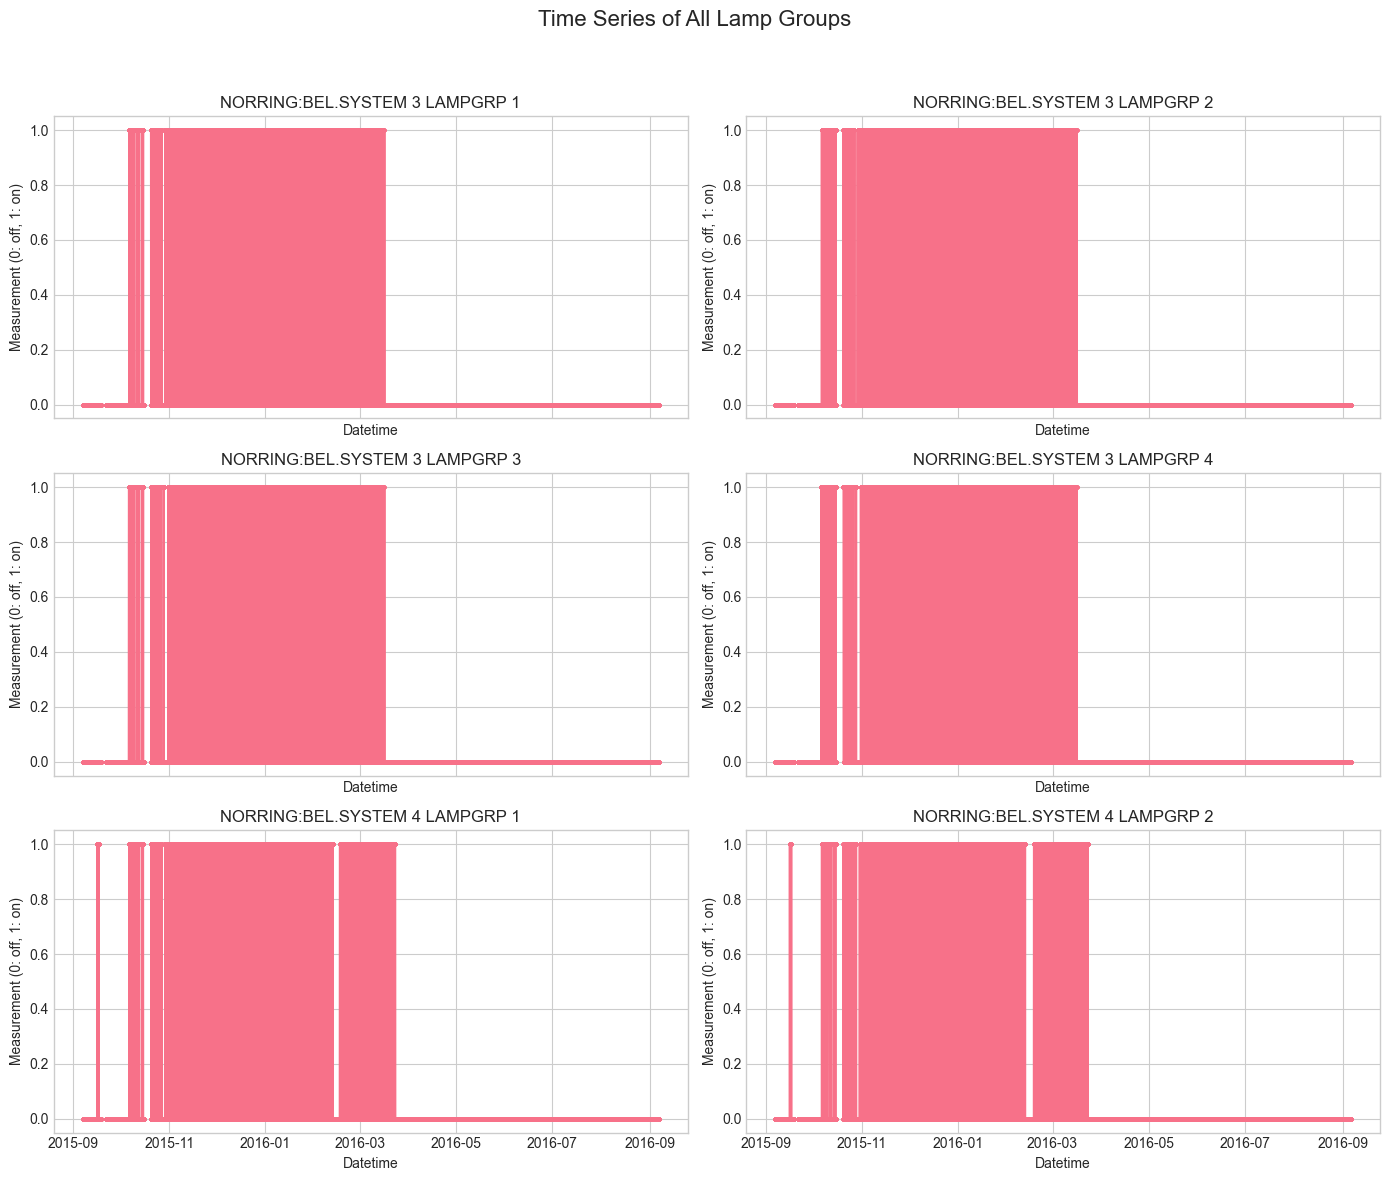

In [17]:
import math

# Identify all sensor (lamp group) columns by excluding "datetime"
sensor_cols = [col for col in knudjepsen_df.columns if col != "datetime"]
n_groups = len(sensor_cols)

# Determine grid layout: use 2 columns and as many rows as needed
ncols = 2
nrows = math.ceil(n_groups / ncols)

# Create subplots with a shared x-axis for better comparison
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 4 * nrows), sharex=True)

# Ensure axes is a flat list even if there's only one subplot
if n_groups == 1:
    axes = [axes]
else:
    axes = axes.flatten()

# Plot time series for each lamp group in its subplot
for i, col in enumerate(sensor_cols):
    axes[i].plot(knudjepsen_df["datetime"], knudjepsen_df[col],
                 marker="o", linestyle="-", markersize=2)
    axes[i].set_title(col)
    axes[i].set_xlabel("Datetime")
    axes[i].set_ylabel("Measurement (0: off, 1: on)")

# Remove any unused subplots (in case the grid has extra slots)
for j in range(n_groups, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Time Series of All Lamp Groups", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

lets try a different approach.

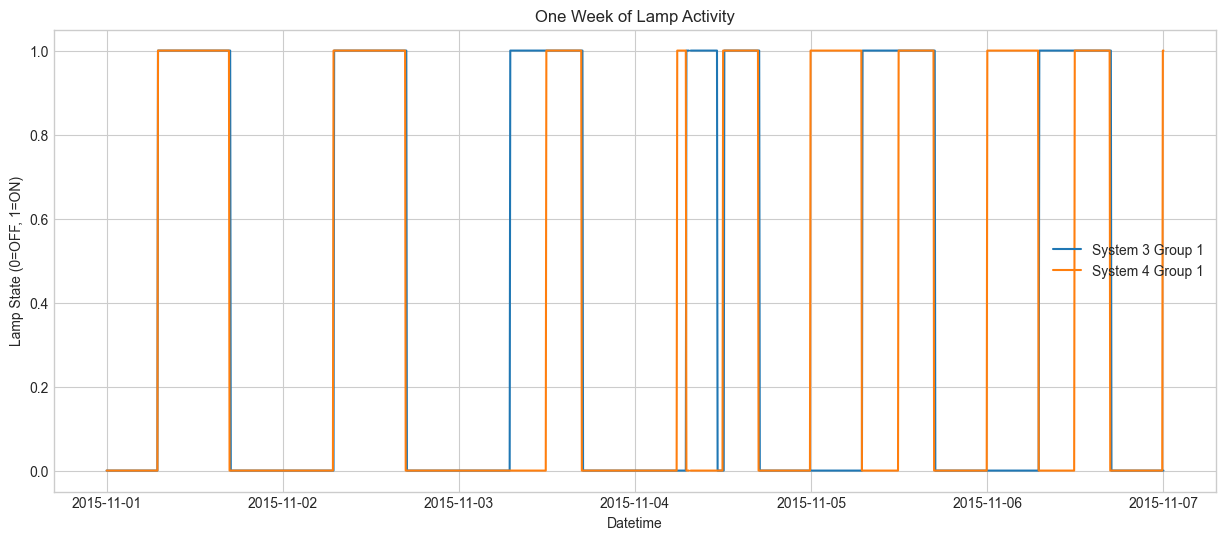

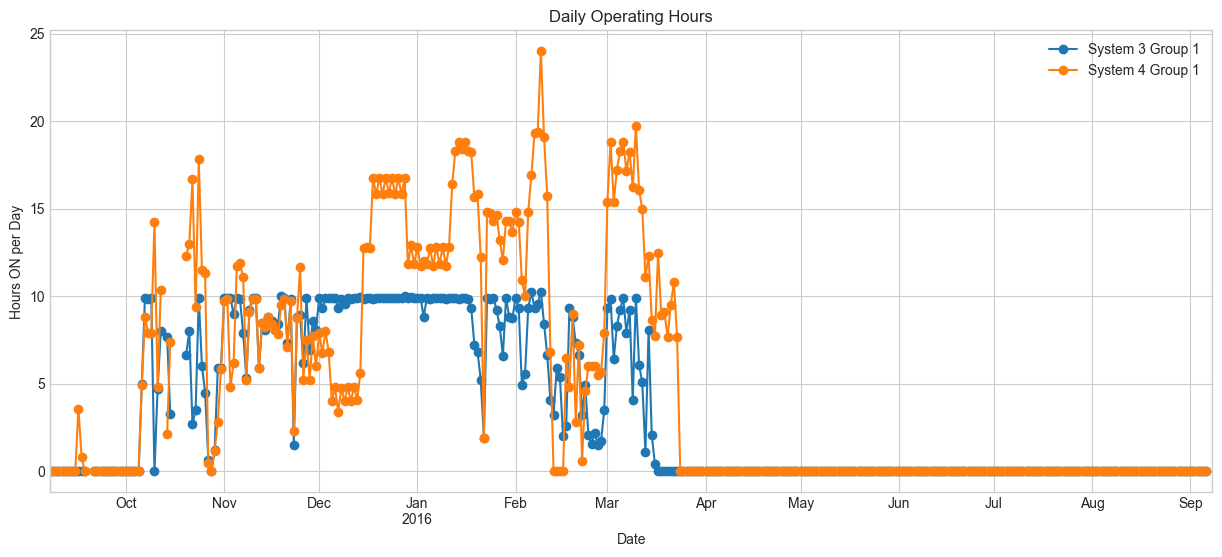

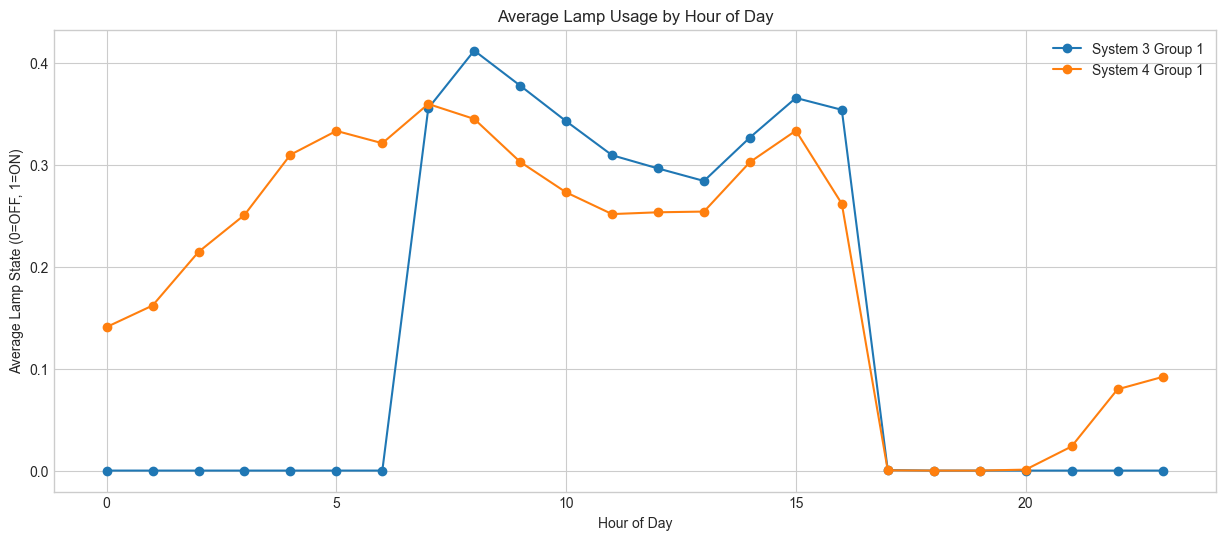

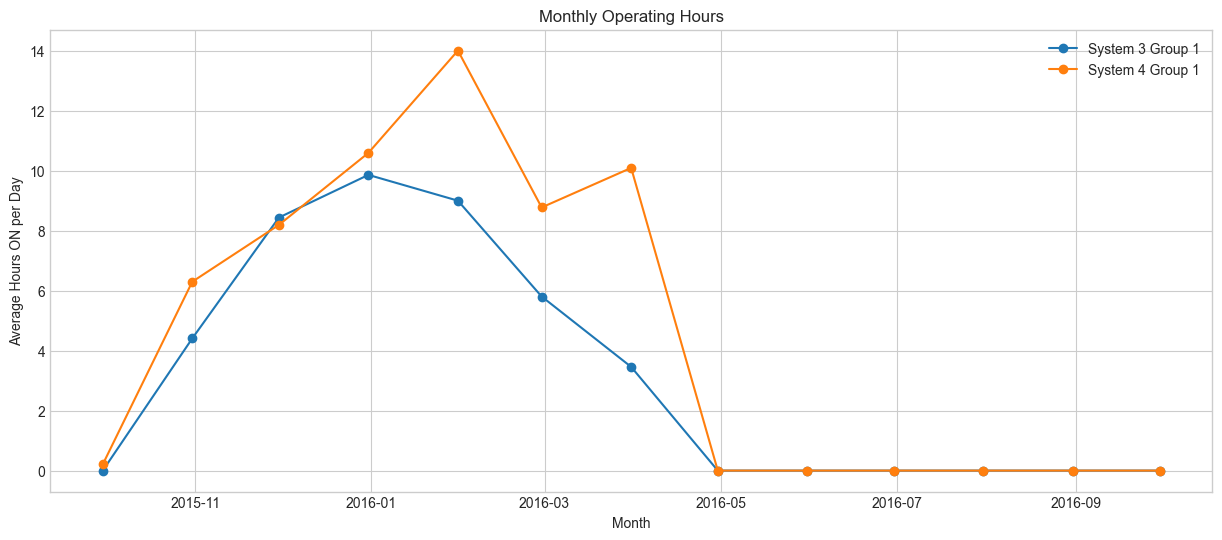

Daily Operating Hours Summary:

NORRING:BEL.SYSTEM 3 LAMPGRP 1  NORRING:BEL.SYSTEM 4 LAMPGRP 1
count                      359.000000                      359.000000
mean                         3.421582                        4.890025
std                          4.301596                        6.356938
min                          0.000000                        0.000000
25%                          0.000000                        0.000000
50%                          0.000000                        0.000000
75%                          8.791667                        9.791667
max                         10.269767                       24.000000

Observations:

- Daily plots and hourly averages indicate the existence of daily patterns in lamp usage.

- The summary statistics show typical on-hours per day for each system.

- Seasonal (monthly) trends might reveal how usage changes over different times of the year.

- Differences between System 3 and System 4 (as visible in both daily and seasonal plots) could suggest that they 
serve different purposes or are activated under different conditions.

In [20]:
# 1. Zoom in on a shorter time period to see daily patterns
plt.figure(figsize=(15, 6))
# Pick a week where there's activity
start_date = '2015-11-01'
end_date = '2015-11-07'
mask = (knudjepsen_df['datetime'] >= start_date) & (knudjepsen_df['datetime'] <= end_date)

plt.plot(
    knudjepsen_df.loc[mask, 'datetime'],
    knudjepsen_df.loc[mask, 'NORRING:BEL.SYSTEM 3 LAMPGRP 1'],
    color='tab:blue',
    label='System 3 Group 1'
)
plt.plot(
    knudjepsen_df.loc[mask, 'datetime'],
    knudjepsen_df.loc[mask, 'NORRING:BEL.SYSTEM 4 LAMPGRP 1'],
    color='tab:orange',
    label='System 4 Group 1'
)
plt.title('One Week of Lamp Activity')
plt.xlabel('Datetime')
plt.ylabel('Lamp State (0=OFF, 1=ON)')
plt.legend()
plt.grid(True)
plt.show()

# 2. Calculate daily operating hours (assuming the average state multiplied by 24 gives on-hours)
daily_hours = knudjepsen_df.set_index('datetime').resample('D').mean() * 24

plt.figure(figsize=(15, 6))
daily_hours['NORRING:BEL.SYSTEM 3 LAMPGRP 1'].plot(marker='o', color='tab:blue', label='System 3 Group 1')
daily_hours['NORRING:BEL.SYSTEM 4 LAMPGRP 1'].plot(marker='o', color='tab:orange', label='System 4 Group 1')
plt.title('Daily Operating Hours')
plt.xlabel('Date')
plt.ylabel('Hours ON per Day')
plt.legend()
plt.grid(True)
plt.show()

# 3. Analyze average lamp usage by hour of day to reveal daily patterns
# Extract the hour component from the datetime column
knudjepsen_df['hour'] = knudjepsen_df['datetime'].dt.hour
hourly_avg = knudjepsen_df.groupby('hour').mean()

plt.figure(figsize=(15, 6))
plt.plot(
    hourly_avg.index,
    hourly_avg['NORRING:BEL.SYSTEM 3 LAMPGRP 1'],
    marker='o',
    color='tab:blue',
    label='System 3 Group 1'
)
plt.plot(
    hourly_avg.index,
    hourly_avg['NORRING:BEL.SYSTEM 4 LAMPGRP 1'],
    marker='o',
    color='tab:orange',
    label='System 4 Group 1'
)
plt.title('Average Lamp Usage by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Lamp State (0=OFF, 1=ON)')
plt.legend()
plt.grid(True)
plt.show()

# 4. Seasonal analysis: calculate and plot monthly operating hours
monthly_hours = knudjepsen_df.set_index('datetime').resample('ME').mean() * 24

plt.figure(figsize=(15, 6))
plt.plot(
    monthly_hours.index,
    monthly_hours['NORRING:BEL.SYSTEM 3 LAMPGRP 1'],
    marker='o',
    color='tab:blue',
    label='System 3 Group 1'
)
plt.plot(
    monthly_hours.index,
    monthly_hours['NORRING:BEL.SYSTEM 4 LAMPGRP 1'],
    marker='o',
    color='tab:orange',
    label='System 4 Group 1'
)
plt.title('Monthly Operating Hours')
plt.xlabel('Month')
plt.ylabel('Average Hours ON per Day')
plt.legend()
plt.grid(True)
plt.show()

# 5. Summary statistics for daily operating hours to help answer:
# - How many hours per day are the lamps typically ON?
# - Do Systems 3 and 4 serve different purposes based on their usage patterns?
daily_summary = daily_hours[['NORRING:BEL.SYSTEM 3 LAMPGRP 1', 'NORRING:BEL.SYSTEM 4 LAMPGRP 1']].describe()
print("Daily Operating Hours Summary:")
print(daily_summary)

print("\nObservations:")
print(" - Daily plots and hourly averages indicate the existence of daily patterns in lamp usage.")
print(" - The summary statistics show typical on-hours per day for each system.")
print(" - Seasonal (monthly) trends might reveal how usage changes over different times of the year.")
print(" - Differences between System 3 and System 4 (as visible in both daily and seasonal plots) could suggest that they serve different purposes or are activated under different conditions.")


#### Lets look at aarslev now

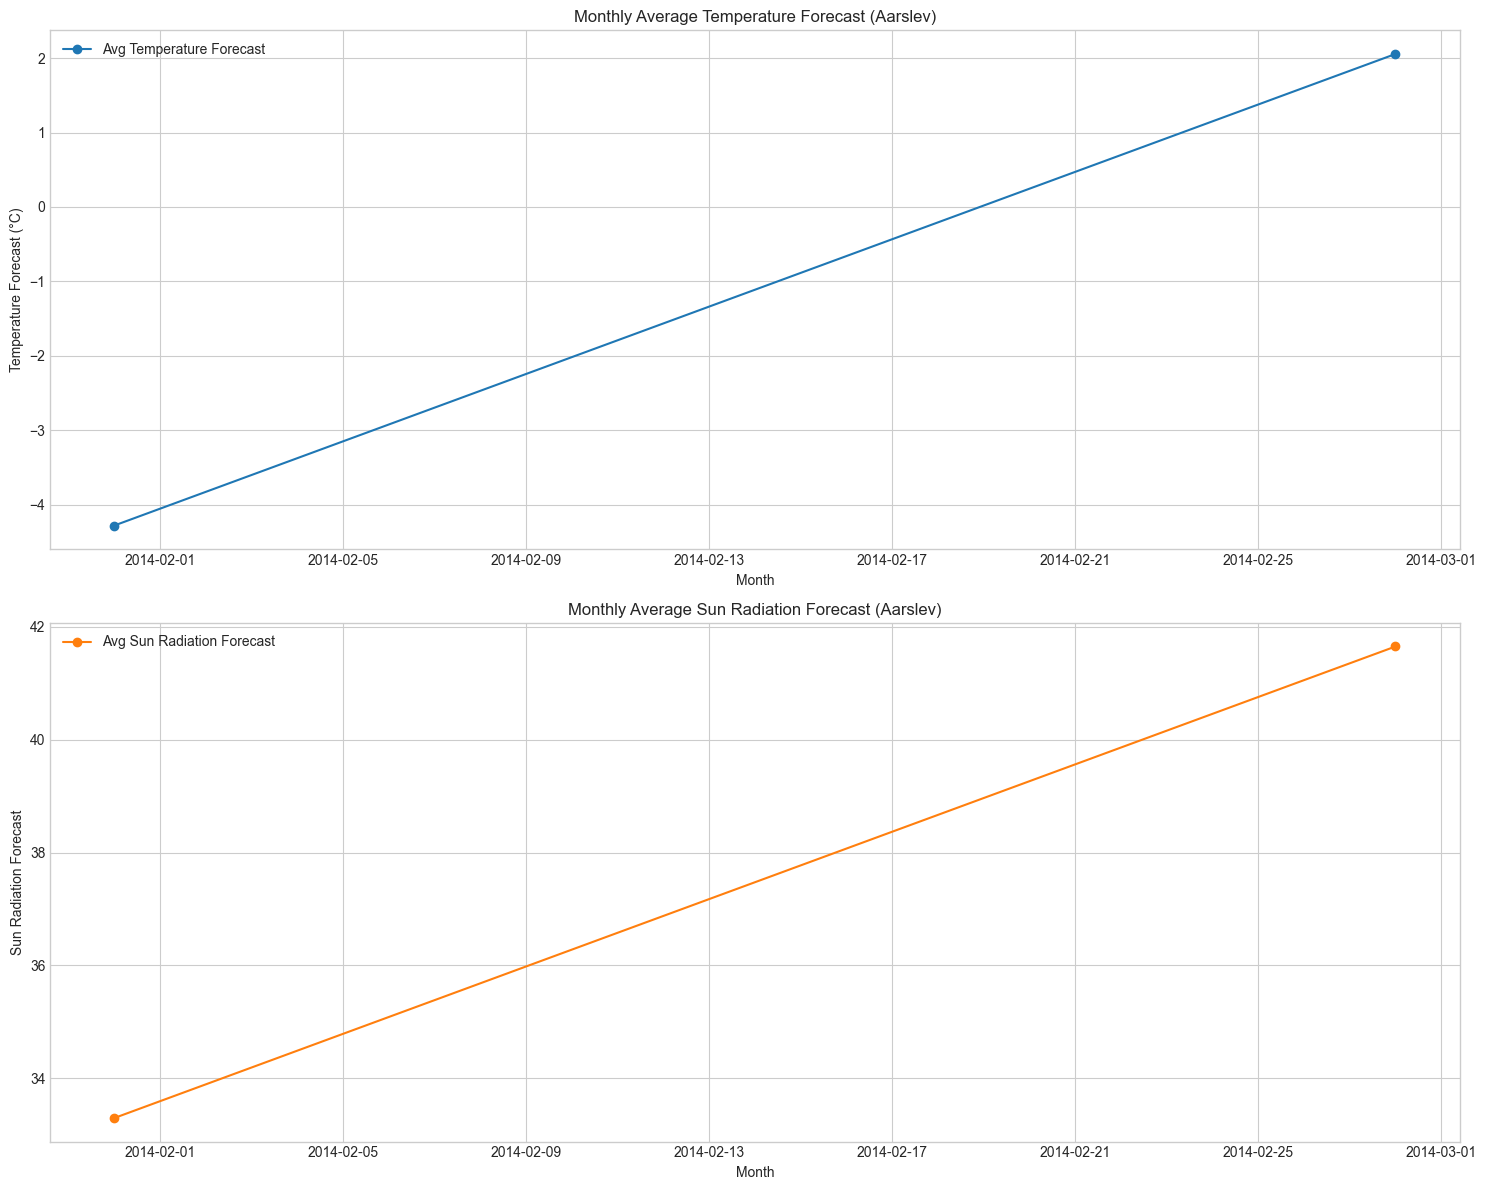

Daily Aarslev Forecast Summary (Temperature & Sun Radiation):

temperature_forecast  sun_radiation_forecast
count             23.000000               23.000000
mean              -0.421045               37.035776
std                3.515299               13.278107
min               -7.419167                0.000000
25%               -3.396250               29.340188
50%                0.586667               40.003542
75%                2.473813               46.040813
max                4.448750               64.387391

In [25]:
# Assuming aarslev_df is already loaded and the necessary libraries are imported

# Ensure that the 'datetime' column exists and set it as the index for resampling
if "datetime" not in aarslev_df.columns:
    aarslev_df["datetime"] = pd.to_datetime(aarslev_df["timestamp"], unit="ms")
aarslev_df.set_index("datetime", inplace=True)

# Seasonal (Monthly) Analysis: Calculate monthly average forecast values
monthly_data: pd.DataFrame = aarslev_df.resample("ME").mean()

plt.figure(figsize=(15, 12))

# Plot Monthly Average Temperature Forecast
plt.subplot(2, 1, 1)
plt.plot(
    monthly_data.index,
    monthly_data["temperature_forecast"],
    marker="o",
    color="tab:blue",
    label="Avg Temperature Forecast"
)
plt.title("Monthly Average Temperature Forecast (Aarslev)")
plt.xlabel("Month")
plt.ylabel("Temperature Forecast (°C)")
plt.legend()
plt.grid(True)

# Plot Monthly Average Sun Radiation Forecast
plt.subplot(2, 1, 2)
plt.plot(
    monthly_data.index,
    monthly_data["sun_radiation_forecast"],
    marker="o",
    color="tab:orange",
    label="Avg Sun Radiation Forecast"
)
plt.title("Monthly Average Sun Radiation Forecast (Aarslev)")
plt.xlabel("Month")
plt.ylabel("Sun Radiation Forecast")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Daily Summary Statistics: Compute daily averages for forecast parameters
daily_data: pd.DataFrame = aarslev_df.resample("D").mean()
print("Daily Aarslev Forecast Summary (Temperature & Sun Radiation):")
print(daily_data[["temperature_forecast", "sun_radiation_forecast"]].describe())


Daily Aarslev Forecast Summary: This summary indicates that the temperature forecast averages -0.42°C with a standard deviation of 3.52, ranging from -7.42°C to 4.45°C, reflecting noticeable fluctuations. Meanwhile, the sun radiation forecast averages 37.04 with moderate variability (std 13.28), with values spanning from 0.0 to 64.39.